In [34]:
'''
This code generate rarefaction curves.
It does so by comparing the raw results from the microscopy, flowcam, and computer predictions.
It resamples the individual taxa with increasingly larger sample sizes and counts the number of taxa in each sample.
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [35]:
#FUNCTIONS
def get_chao2(df):
    # Sample Data: Species names and their counts (can be from a DataFrame)
    # Let's assume this is a dataset with columns: 'species' and 'count'
    
    # Calculate F1 (singletons) and F2 (doubletons)
    F1 = (df['countSample'] == 1).sum()  # Number of species that appear exactly once
    F2 = (df['countSample'] == 2).sum()  # Number of species that appear exactly twice
    
    # Total observed species (S_obs)
    S_obs = df.shape[0]  # The number of unique species observed
    
    # Chao2 estimator formula
    S_Chao2 = S_obs + (F1 * (F1 - 1)) / (2 * (F2 + 1))
    
    # Output the results
    print(f"Observed species (S_obs): {S_obs}")
    print(f"Singletons (F1): {F1}")
    print(f"Doubletons (F2): {F2}")
    print(f"Chao2 Estimate: {S_Chao2}")
    return S_Chao2

def get_increment(max_num, interval):
    divider = max_num - max_num % interval    
    return divider / interval

def plot_rarefaction_curve(df, chao2, max_sample):

    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    
    def rarefaction_curve(df, max_sample_size, num_iterations=1000):
        print('num of species: ', len(df))
        print(df['newName'])
        newNames = df['newName'].to_numpy()
        probs = df['probs'].to_numpy()
        species_counts = df['countSample'].values  # Counts of each species
        name_basket = []
        for i, newName in enumerate(newNames):
            for _ in range(species_counts[i]):
                name_basket.append(newName)
        richness_list = []  # List to store species richness for each sample size
        increment = get_increment(max_sample_size, 30)
        print("increment: ", increment)
        for sample_size in range(0, max_sample_size + 1):
            if not sample_size % increment == 0:
                continue
            species_richness = []
    
            for _ in range(num_iterations):
                # Randomly sample individuals from the species counts
                sampled =np.random.choice(name_basket, sample_size, replace=False)
                # Count the number of unique species observed in this random sample
                observed_species = len(np.unique(sampled))  # Species present if count > 0
                species_richness.append(observed_species)
            richness_list.append(np.mean(species_richness))
            # if np.mean(species_richness) >= len(df):
            #     break
            # Calculate the average species richness for the current sample size
            # print("mean of species_richness: ", np.mean(species_richness))
        return richness_list, increment
    
    # Get the rarefaction curve
    richness, increment = rarefaction_curve(df, min(sum_counts, 8525), 200)
    # Plot the rarefaction curve
    plt.figure(figsize=(8, 6))
    plt.plot(np.array(range(len(richness))) * increment, richness)
    plt.axhline(y=chao2, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=len(df), color='red', linestyle='-', linewidth=2)
    plt.title('Rarefaction Curve')
    plt.xlabel('Number of Individuals Sampled')
    plt.ylabel('Species Richness (Observed Species)')
    plt.grid(True)
    plt.show()
    plt.close()
    return richness, sum_counts, increment, len(df)

def get_redundant_count_names(abunddf, countdf, type):
    typeAbunddf = abunddf[abunddf['type'] == type]
    abundNames = typeAbunddf['newName'].unique()
    countNames = countdf['newName'].unique()
    unique_to_abund = np.setdiff1d(abundNames, countNames)
    unique_to_count = np.setdiff1d(countNames, abundNames)
    print("unique to abund: ", unique_to_abund)
    print("unique to count: ", unique_to_count)
    return unique_to_count


In [36]:

nameChangesFile = pd.ExcelFile('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperZooNameChanges.xlsx')
sheet_names = nameChangesFile.sheet_names
nameChanges = pd.read_excel(nameChangesFile, sheet_names[1])
ogNames = nameChanges['flowcamName'].to_numpy()
newNames = nameChanges['newName'].to_numpy()
changeDict = {}
for i, ogname in enumerate(ogNames):
    changeDict[ogname] = newNames[i]

changeDict['Chaetognatha (juvenile or n.s.)']= 'Chaetognatha'
changeDict['Sarsia_spp_medusa']= 'Sarsia spp. (medusa)'


In [37]:
datadf = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperDataForFigures.xlsx')

In [42]:
# this cleans the the redundant taxa from the microscopy data (like eggs)

hm_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/microscopyDataMethodPaper_RawCounts.xlsx')
hm_rawcounts_df = hm_rawcounts_df[['FlowCamID', 'newName', 'regionYear', 'Subsample fraction', 'countSample']]
#check which names are in rawcounts but not in the abundance data sheet. Remove them and print them.
hm_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hm_rawcounts_df, 'MC')
print(len(hm_rawcounts_df['newName'].unique()))
hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(hm_rawcounts_df_redundant_names)]
len(hm_rawcounts_df['newName'].unique())

unique to abund:  []
unique to count:  ['Decapoda: Distribute abundances between non-brachyura and brachyura'
 'Egg mass: REMOVE' 'Invertebrate (egg, trochophore larvae)']
50


47

In [59]:
#rename problem taxa

newName_removals = ['Alciopidae sp.', 'Neoturris spp. (medusa)', 'Scyphozoa (medusa)']

newName_changes = {'Ctenophora (juvenile/adult)': 'Ctenophora (larvae)',
                  'Amphipoda- epibenthic': 'Amphipoda',
                   'Calycophorae (nectophore)': 'Siphonophorae (nectophore)',
                   'Ctenophora larvae': 'Ctenophora (larvae)'
                  }


hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(newName_removals)]
hm_rawcounts_df = hm_rawcounts_df.replace(newName_changes)
hm_names = hm_rawcounts_df['newName'].unique()
hm_names.sort()
print(len(hm_names))
hm_names

43


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Centropages spp.',
       'Chaetognatha', 'Cirripedia (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.', 'Eurytemora spp.',
       'Evadne spp.', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)',
       'Microcalanus spp.', 'Obelia spp. (medusa)', 'Oikopleura spp.',
       'Oithona spp.', 'Osteichthyes (larvae)', 'Paracalanus spp.',
       'Platyhelminthes/Nemertea (juvenile)',
       'Platyhelminthes/Nemertea (larvae)', 'Podon/Pleopsis spp.',
       'Polychaeta (larvae)', 'Pseudocalanus spp.',
       'Pseudodiaptomus spp.', 'Sarsia spp. (me

['NL 2021' 'NL 2020' 'Gulf 2020' 'Pac 21']
NL 2021
5855
Observed species (S_obs): 25
Singletons (F1): 2
Doubletons (F2): 1
Chao2 Estimate: 25.5
num of species:  25
0                     Acartia spp.
1           Aglantha spp. (medusa)
2                Bivalvia (larvae)
3                 Bryozoa (larvae)
4              Calanoida (ci-ciii)
5                     Calanus spp.
6                 Centropages spp.
7                     Chaetognatha
8           Echinodermata (larvae)
9                  Eurytemora spp.
10                     Evadne spp.
11                Fritillaria spp.
12    Gastropoda (larvae/Limacina)
13       Harpacticoida- epibenthic
14               Hydrozoa (medusa)
15               Microcalanus spp.
16            Obelia spp. (medusa)
17                 Oikopleura spp.
18                    Oithona spp.
19             Podon/Pleopsis spp.
20             Polychaeta (larvae)
21              Pseudocalanus spp.
22            Sarsia spp. (medusa)
23                     Temora s

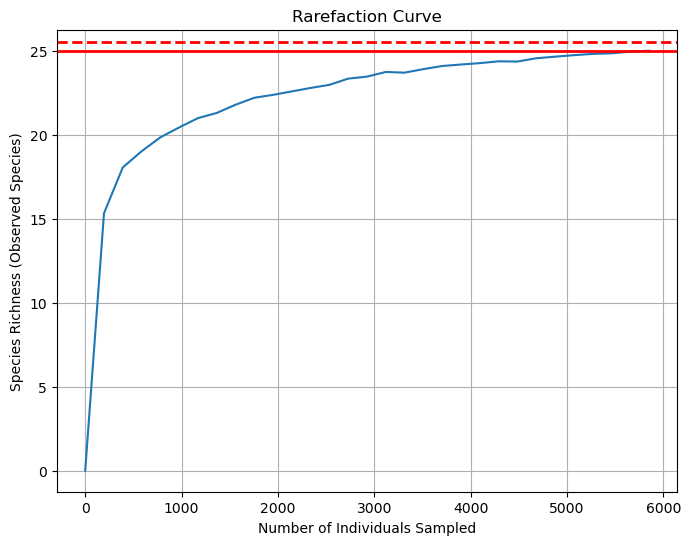

NL 2020
2387
Observed species (S_obs): 16
Singletons (F1): 1
Doubletons (F2): 0
Chao2 Estimate: 16.0
num of species:  16
0                     Acartia spp.
1                Bivalvia (larvae)
2              Calanoida (ci-ciii)
3                     Calanus spp.
4                 Centropages spp.
5                  Eurytemora spp.
6                      Evadne spp.
7     Gastropoda (larvae/Limacina)
8        Harpacticoida- epibenthic
9                Hydrozoa (medusa)
10               Microcalanus spp.
11                 Oikopleura spp.
12                    Oithona spp.
13             Podon/Pleopsis spp.
14              Pseudocalanus spp.
15                     Temora spp.
Name: newName, dtype: object
increment:  79.0


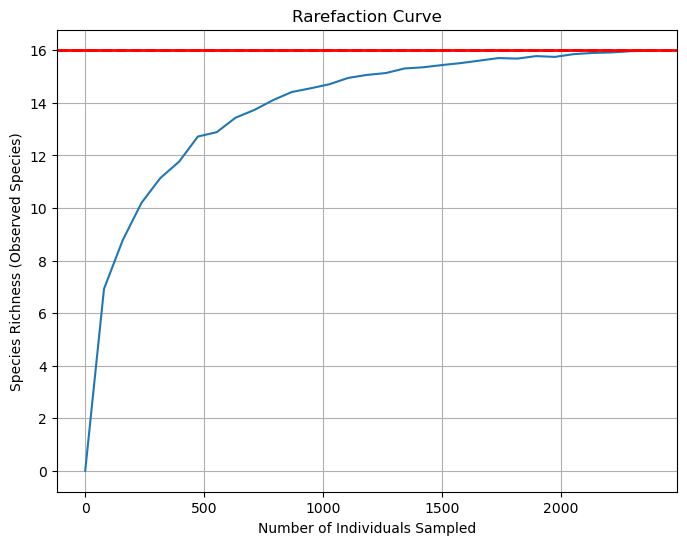

Gulf 2020
3045
Observed species (S_obs): 21
Singletons (F1): 2
Doubletons (F2): 1
Chao2 Estimate: 21.5
num of species:  21
0                     Acartia spp.
1              Ascidiacea (larvae)
2                Bivalvia (larvae)
3                 Bryozoa (larvae)
4              Calanoida (ci-ciii)
5                 Centropages spp.
6                     Chaetognatha
7              Cirripedia (larvae)
8               Copepoda (nauplii)
9           Echinodermata (larvae)
10                     Evadne spp.
11    Gastropoda (larvae/Limacina)
12       Harpacticoida- epibenthic
13               Hydrozoa (medusa)
14            Obelia spp. (medusa)
15                    Oithona spp.
16             Podon/Pleopsis spp.
17             Polychaeta (larvae)
18              Pseudocalanus spp.
19            Pseudodiaptomus spp.
20                     Temora spp.
Name: newName, dtype: object
increment:  101.0


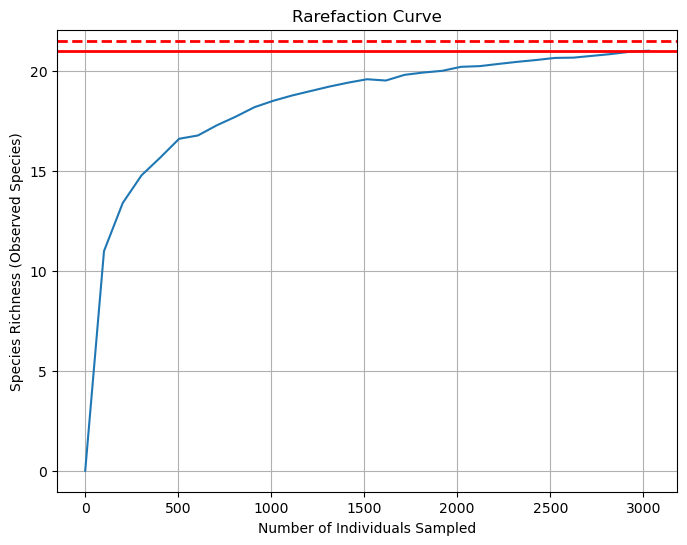

Pac 21
4824
Observed species (S_obs): 37
Singletons (F1): 7
Doubletons (F2): 1
Chao2 Estimate: 47.5
num of species:  37
0                            Acartia spp.
1                               Amphipoda
2                     Ascidiacea (larvae)
3                       Bivalvia (larvae)
4                        Bryozoa (larvae)
5                     Calanoida (ci-ciii)
6                        Centropages spp.
7                            Chaetognatha
8                     Cirripedia (larvae)
9                      Copepoda (nauplii)
10                            Corycaeidae
11                    Ctenophora (larvae)
12           Decapoda- brachyura (larvae)
13       Decapoda- non-brachyura (larvae)
14                 Echinodermata (larvae)
15                     Epilabidocera spp.
16                            Evadne spp.
17                       Fritillaria spp.
18           Gastropoda (larvae/Limacina)
19              Harpacticoida- epibenthic
20                      Hydrozoa (medusa

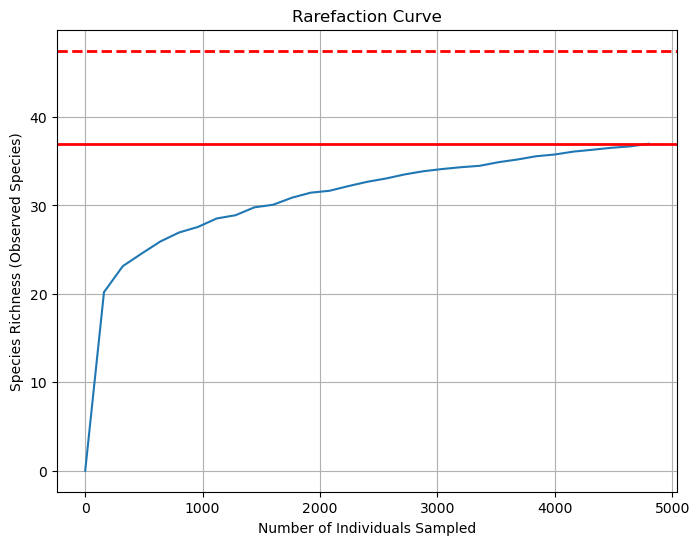

In [47]:
# calculate and plot curves for microscopy (HM)
regionYears = hm_rawcounts_df['regionYear'].unique()
print(regionYears)
hm_region_richness = {}
hm_sum_counts = {}
hm_increments = {}
hm_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao2 = get_chao2(sample_counts)
    hm_region_richness[regionYear], hm_sum_counts[regionYear], hm_increments[regionYear], hm_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao2, max_sample = 10000)

In [82]:
hi_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/flowcamDataMethodPaper_RawCounts.xlsx')
hi_rawcounts_df = hi_rawcounts_df[['qaSampleID', 'originalNames', 'dataset', 'fracSampleCleaned', 'count']]
hi_rawcounts_df = hi_rawcounts_df.rename(columns={'qaSampleID': 'FlowCamID', 'originalNames': 'newName', 'dataset':'regionYear', 'count': 'countSample'})
hi_rawcounts_df['newName'] = hi_rawcounts_df['newName'].replace(changeDict)
hi_rawcounts_df['regionYear'] = hi_rawcounts_df['regionYear'].replace({'Newfoundland 2020': 'NL 2020', 'Pacific June 2021': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'})
hi_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hi_rawcounts_df, 'FC')
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Oncaeidae_Civ-vi']
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Sarsia spp. (medusa)']
print(len(hi_rawcounts_df['newName'].unique()))
hi_rawcounts_df = hi_rawcounts_df[~hi_rawcounts_df['newName'].isin(hi_rawcounts_df_redundant_names)]
print(len(hi_rawcounts_df['newName'].unique()))
hi_names = hi_rawcounts_df['newName'].unique()
hi_names.sort()
hi_names

unique to abund:  []
unique to count:  ['Calanoida (unid)' 'Copepoda (unid)' 'Cyclopoida (unid)'
 'Invertebrate (egg, trochophore larvae)' 'Oncaeidae_Civ-vi'
 'Osteichthyes egg' 'Osteichthyes_eggs' 'Sarsia spp. (medusa)'
 'Zooplankton (unid)']
55
48


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Calycophorae (nectophore)', 'Centropages spp.',
       'Chaetognatha', 'Chiridius spp.', 'Cirripedia (larvae)',
       'Cnidaria (larvae)', 'Copepoda (nauplii)', 'Corycaeidae',
       'Ctenophora larvae', 'Decapoda- brachyura (larvae)',
       'Decapoda- non-brachyura (larvae)', 'Echinodermata (larvae)',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae

In [83]:

hi_rawcounts_df = hi_rawcounts_df.replace(newName_changes)
flow_names = hi_rawcounts_df['newName'].unique()
flow_names.sort()
flow_names

array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Centropages spp.', 'Chaetognatha',
       'Chiridius spp.', 'Cirripedia (larvae)', 'Cnidaria (larvae)',
       'Copepoda (nauplii)', 'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Euphysa spp. (medusa)',
       'Eurytemora spp.', 'Evadne spp.', 'Foraminifera',
       'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae)',
       'Pseudocalanus s

In [84]:
hi_rawcounts_df[hi_rawcounts_df['newName'] == 'Oncaeidae_Civ-vi']

,FlowCamID,newName,regionYear,fracSampleCleaned,countSample
235,21-10-5-NL-S1-Z17-1406-250,Oncaeidae_Civ-vi,NL 2021,1.0,1
261,21-10-5-NL-S1-Z41-854-250,Oncaeidae_Civ-vi,NL 2021,1.0,4
316,21-10-6-NL-S1-Z17-802-250,Oncaeidae_Civ-vi,NL 2021,1.0,1


In [75]:
pacific_flow_names = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == 'Pacific']['newName'].unique()
# print(pacific_flow_names)
pacific_mic_names = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == 'Pac 21']['newName'].unique()
unique_to_flow = np.setdiff1d(pacific_flow_names, pacific_mic_names)
unique_to_mic = np.setdiff1d(pacific_mic_names, pacific_flow_names)
print(unique_to_flow)
print(unique_to_mic)

['Calanus spp.' 'Euphysa spp. (medusa)' 'Ostracoda']
['Amphipoda' 'Chaetognatha' 'Epilabidocera spp.'
 'Harpacticoida- epibenthic' 'Isopoda (larvae)'
 'Leuckartiara spp. (medusa)' 'Obelia spp. (medusa)'
 'Platyhelminthes/Nemertea (juvenile)' 'Platyhelminthes/Nemertea (larvae)'
 'Sarsia spp. (medusa)' 'Scyphozoa (larvae)']


In [79]:
hm_rawcounts_df[(hm_rawcounts_df['newName'].isin(unique_to_mic)) & (hm_rawcounts_df['regionYear'] == 'Pac 21')]

,FlowCamID,newName,regionYear,Subsample fraction,countSample
460,AMMP_PA_S04W01_20210609LT_250um,Harpacticoida- epibenthic,Pac 21,0.039062,1
466,AMMP_PA_S04W01_20210609LT_250um,Platyhelminthes/Nemertea (juvenile),Pac 21,0.039062,1
487,AMMP_PA_S04W15_20210609LT_250um,Obelia spp. (medusa),Pac 21,0.031250,1
521,AMMP_PA_S04W15_20210609LT_250um,Chaetognatha,Pac 21,1.000000,1
522,AMMP_PA_S04W15_20210609LT_250um,Leuckartiara spp. (medusa),Pac 21,1.000000,2
562,AMMP_PA_S04W20_20210609LT_250um,Sarsia spp. (medusa),Pac 21,1.000000,1
565,AMMP_PA_S04W20_20210609LT_250um,Scyphozoa (larvae),Pac 21,1.000000,1
602,AMMP_PA_S04W01_20210609HT_250um,Chaetognatha,Pac 21,1.000000,1
639,AMMP_PA_S04W15_20210609HT_250um,Sarsia spp. (medusa),Pac 21,1.000000,1
662,AMMP_PA_S04W20_20210609HT_250um,Isopoda (larvae),Pac 21,0.046875,1


In [80]:
hi_rawcounts_df[(hi_rawcounts_df['newName'].isin(unique_to_flow)) & (hi_rawcounts_df['regionYear'] == 'Pacific')]

,FlowCamID,newName,regionYear,fracSampleCleaned,countSample
640,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Calanus spp.,Pacific,0.107273,1
650,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,0.107273,1
658,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Ostracoda,Pacific,0.107273,4
686,AMMP_Pacific_S04W15_250um_Low_2021-06-09,Ostracoda,Pacific,0.146168,3
693,AMMP_Pacific_S04W15_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,1.000000,1
698,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Calanus spp.,Pacific,0.111045,1
706,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,0.111045,1
713,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Ostracoda,Pacific,0.111045,2
725,AMMP_Pacific_S04W01_250um_High_2021-06-09,Calanus spp.,Pacific,0.086603,1
759,AMMP_Pacific_S04W15_250um_High_2021-06-09,Calanus spp.,Pacific,0.113390,1


In [52]:
hi_rawcounts_df[hi_rawcounts_df['regionYear'] == 'NL 2021']['countSample'].sum()


8525

['NL 2020' 'NL 2021' 'Gulf' 'Pacific']
NL 2020
41043
Observed species (S_obs): 27
Singletons (F1): 4
Doubletons (F2): 3
Chao2 Estimate: 28.5
num of species:  27
0                         Acartia spp.
1               Aglantha spp. (medusa)
2                            Amphipoda
3               Anthoathecata (medusa)
4                    Bivalvia (larvae)
5                         Calanus spp.
6                     Centropages spp.
7                         Chaetognatha
8                       Chiridius spp.
9                    Cnidaria (larvae)
10    Decapoda- non-brachyura (larvae)
11              Echinodermata (larvae)
12                     Eurytemora spp.
13                         Evadne spp.
14                    Fritillaria spp.
15        Gastropoda (larvae/Limacina)
16           Harpacticoida- epibenthic
17                   Hydrozoa (medusa)
18                       Metridia spp.
19                Obelia spp. (medusa)
20                     Oikopleura spp.
21                  

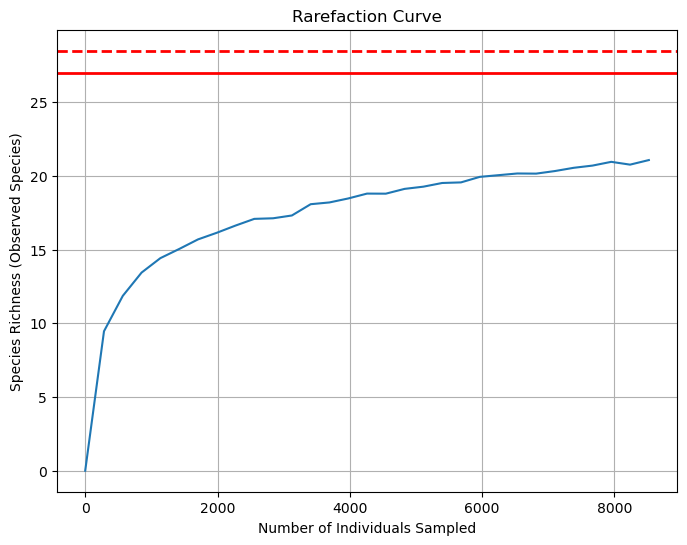

NL 2021
8525
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 2
Chao2 Estimate: 29.333333333333332
num of species:  29
0                         Acartia spp.
1               Aglantha spp. (medusa)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                         Chaetognatha
8     Decapoda- non-brachyura (larvae)
9               Echinodermata (larvae)
10                     Eurytemora spp.
11                         Evadne spp.
12                        Foraminifera
13                    Fritillaria spp.
14        Gastropoda (larvae/Limacina)
15           Harpacticoida- epibenthic
16                   Hydrozoa (medusa)
17                   Microcalanus spp.
18                       Monstrillidae
19                     Oikopleura spp.
20                        Oithona spp.
21                    Oncaeidae_Civ-vi
22     

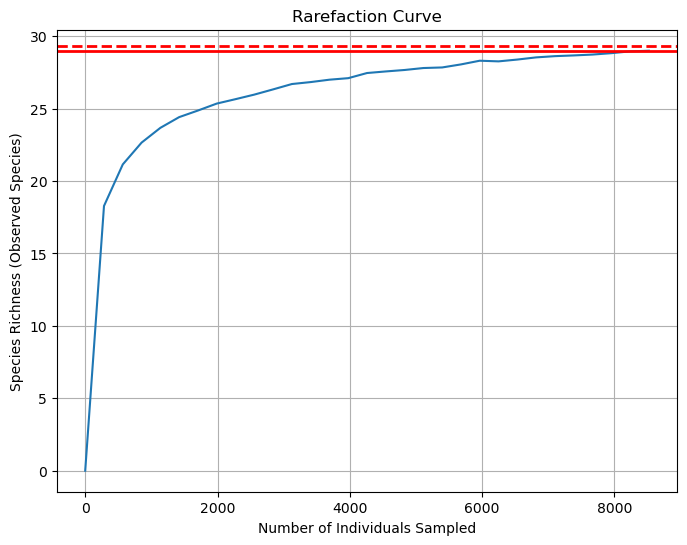

Gulf
39036
Observed species (S_obs): 32
Singletons (F1): 6
Doubletons (F2): 2
Chao2 Estimate: 37.0
num of species:  32
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                     Centropages spp.
6                         Chaetognatha
7                  Cirripedia (larvae)
8                    Cnidaria (larvae)
9                   Copepoda (nauplii)
10        Decapoda- brachyura (larvae)
11    Decapoda- non-brachyura (larvae)
12              Echinodermata (larvae)
13                     Eurytemora spp.
14                         Evadne spp.
15                    Fritillaria spp.
16        Gastropoda (larvae/Limacina)
17           Harpacticoida- epibenthic
18                   Hydrozoa (medusa)
19                   Microsetella spp.
20                       Monstrillidae
21                Obelia spp. (medusa)
22                     

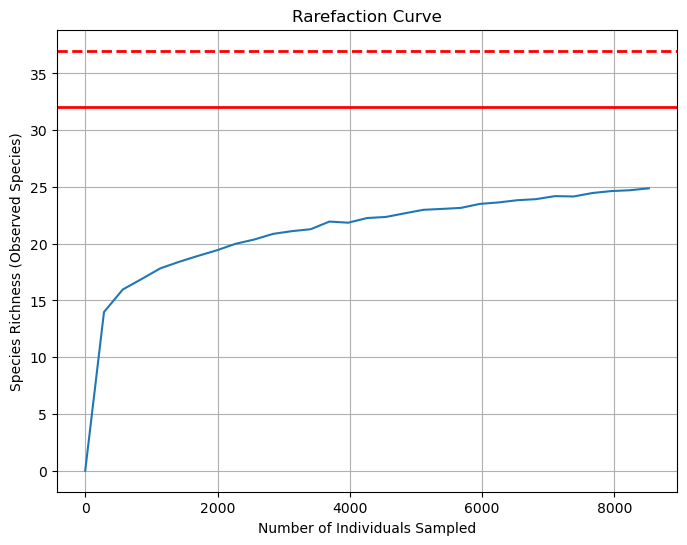

Pacific
10220
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 0
Chao2 Estimate: 30.0
num of species:  29
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                  Cirripedia (larvae)
8                   Copepoda (nauplii)
9                          Corycaeidae
10                 Ctenophora (larvae)
11        Decapoda- brachyura (larvae)
12    Decapoda- non-brachyura (larvae)
13              Echinodermata (larvae)
14               Euphysa spp. (medusa)
15                         Evadne spp.
16                    Fritillaria spp.
17        Gastropoda (larvae/Limacina)
18                   Hydrozoa (medusa)
19                     Oikopleura spp.
20                        Oithona spp.
21               Osteichthyes (larvae)
22                  

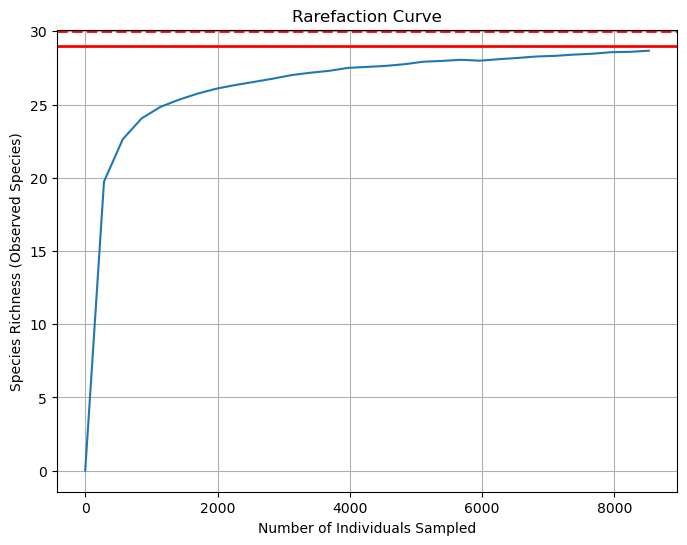

In [64]:
regionYears = hi_rawcounts_df['regionYear'].unique()
print(regionYears)
hi_region_richness = {}
hi_sum_counts = {}
hi_increments = {}
hi_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao2 = get_chao2(sample_counts)
    hi_region_richness[regionYear], hi_sum_counts[regionYear], hi_increments[regionYear], hi_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao2, max_sample = 10000)

In [65]:
cidf = datadf = pd.read_excel('strat4_5000.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})
ci_rawcounts_df = ci_rawcounts_df.replace(newName_changes)

['NL 2021' 'Gulf 2020' 'NL 2020' 'Pac 21']
NL 2021
8362
Observed species (S_obs): 24
Singletons (F1): 0
Doubletons (F2): 1
Chao2 Estimate: 24.0
num of species:  24
0                     Acartia spp.
1                Bivalvia (larvae)
2                 Bryozoa (larvae)
3              Calanoida (ci-ciii)
4                     Calanus spp.
5                 Centropages spp.
6                     Chaetognatha
7              Cirripedia (larvae)
8               Copepoda (nauplii)
9           Echinodermata (larvae)
10           Euphausiacea (larvae)
11          Euphausiacea (nauplii)
12                     Evadne spp.
13                Fritillaria spp.
14    Gastropoda (larvae/Limacina)
15       Harpacticoida- epibenthic
16               Microcalanus spp.
17            Obelia spp. (medusa)
18                 Oikopleura spp.
19                    Oithona spp.
20             Podon/Pleopsis spp.
21             Polychaeta (larvae)
22              Pseudocalanus spp.
23                     Temora s

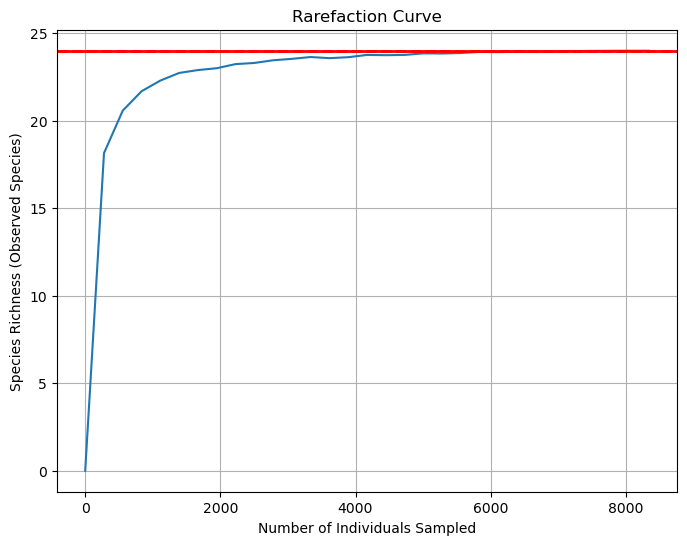

Gulf 2020
39010
Observed species (S_obs): 29
Singletons (F1): 0
Doubletons (F2): 0
Chao2 Estimate: 29.0
num of species:  29
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                  Cirripedia (larvae)
8                   Copepoda (nauplii)
9         Decapoda- brachyura (larvae)
10    Decapoda- non-brachyura (larvae)
11              Echinodermata (larvae)
12                     Eurytemora spp.
13                         Evadne spp.
14                    Fritillaria spp.
15        Gastropoda (larvae/Limacina)
16           Harpacticoida- epibenthic
17                   Hydrozoa (medusa)
18                     Labidocera spp.
19                Obelia spp. (medusa)
20                        Oithona spp.
21               Osteichthyes (larvae)
22                

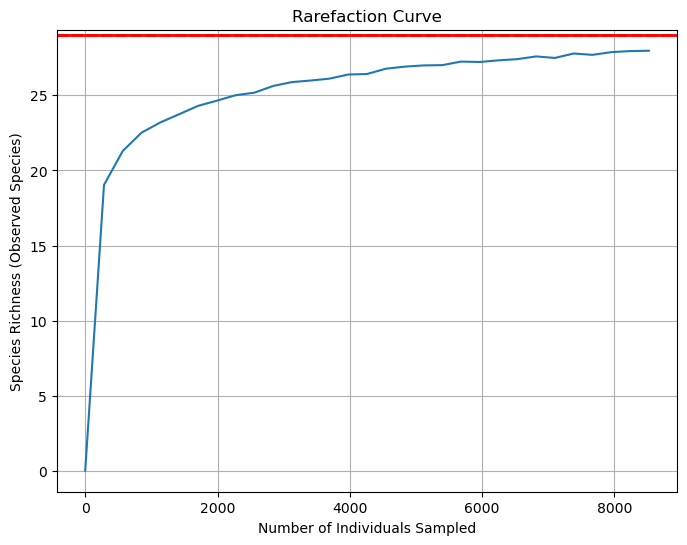

NL 2020
40923
Observed species (S_obs): 24
Singletons (F1): 1
Doubletons (F2): 1
Chao2 Estimate: 24.0
num of species:  24
0                     Acartia spp.
1                Bivalvia (larvae)
2                 Bryozoa (larvae)
3              Calanoida (ci-ciii)
4                     Calanus spp.
5                 Centropages spp.
6                     Chaetognatha
7              Cirripedia (larvae)
8               Copepoda (nauplii)
9           Echinodermata (larvae)
10           Euphausiacea (larvae)
11          Euphausiacea (nauplii)
12                 Eurytemora spp.
13                     Evadne spp.
14                Fritillaria spp.
15    Gastropoda (larvae/Limacina)
16       Harpacticoida- epibenthic
17               Microcalanus spp.
18                 Oikopleura spp.
19                    Oithona spp.
20             Podon/Pleopsis spp.
21             Polychaeta (larvae)
22              Pseudocalanus spp.
23                     Temora spp.
Name: newName, dtype: object
increment

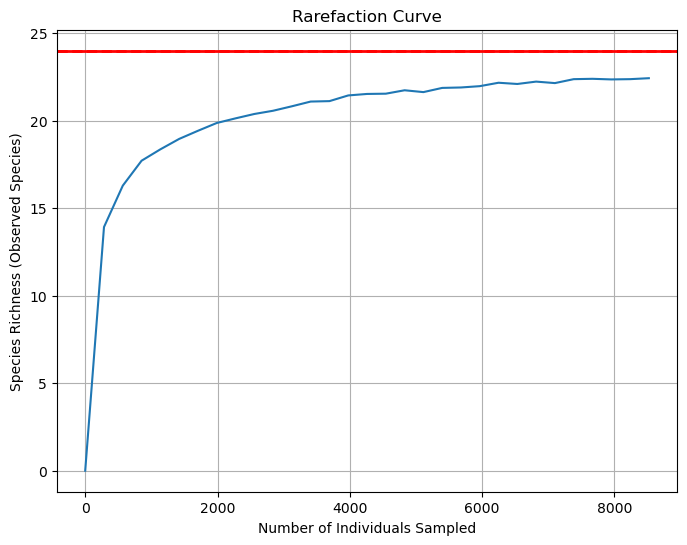

Pac 21
9965
Observed species (S_obs): 25
Singletons (F1): 0
Doubletons (F2): 0
Chao2 Estimate: 25.0
num of species:  25
0                          Acartia spp.
1                   Ascidiacea (larvae)
2                     Bivalvia (larvae)
3                      Bryozoa (larvae)
4                   Calanoida (ci-ciii)
5                      Centropages spp.
6                   Cirripedia (larvae)
7                    Copepoda (nauplii)
8                           Corycaeidae
9          Decapoda- brachyura (larvae)
10     Decapoda- non-brachyura (larvae)
11               Echinodermata (larvae)
12                          Evadne spp.
13                     Fritillaria spp.
14         Gastropoda (larvae/Limacina)
15                    Hydrozoa (medusa)
16                      Oikopleura spp.
17                         Oithona spp.
18                     Paracalanus spp.
19    Platyhelminthes/Nemertea (larvae)
20                  Podon/Pleopsis spp.
21                  Polychaeta (larvae)


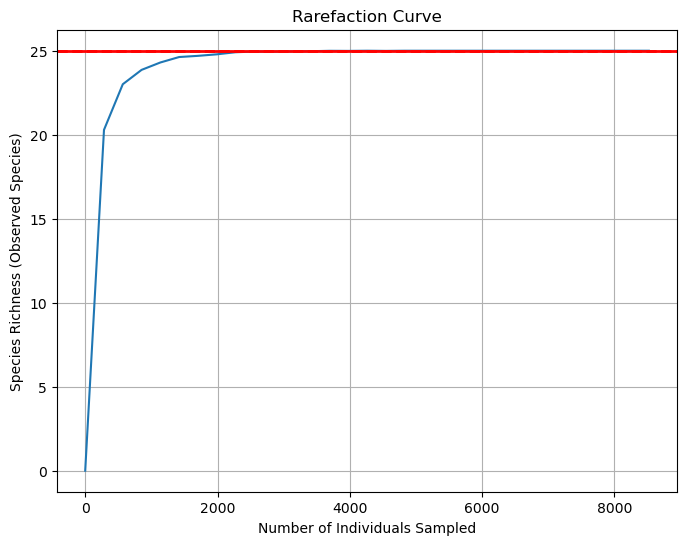

In [66]:
regionYears = ci_rawcounts_df['regionYear'].unique()
print(regionYears)
ci_rawcounts_df['countSample'] = ci_rawcounts_df['countSample'].astype(int)
ci_region_richness = {}
ci_sum_counts = {}
ci_increments = {}
ci_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao2 = get_chao2(sample_counts)
    ci_region_richness[regionYear], ci_sum_counts[regionYear], ci_increments[regionYear], ci_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao2, max_sample = 10000)

In [67]:
#changing regionYear keys to their new names

# Define a mapping of old keys to new keys
key_mapping = {'Newfoundland 2020': 'NL 2020', 'Pac 21': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'}

# # Replace keys using dictionary comprehension
hm_region_richness = {key_mapping.get(k, k): v for k, v in hm_region_richness.items()}
hm_increments = {key_mapping.get(k, k): v for k, v in hm_increments.items()}
hm_total_species = {key_mapping.get(k, k): v for k, v in hm_total_species.items()}
ci_region_richness = {key_mapping.get(k, k): v for k, v in ci_region_richness.items()}
ci_increments = {key_mapping.get(k, k): v for k, v in ci_increments.items()}
ci_total_species = {key_mapping.get(k, k): v for k, v in ci_total_species.items()}

In [68]:
np.array(range(len(richness))) * hi_increments[regionYear]

KeyError: 'Pac 21'

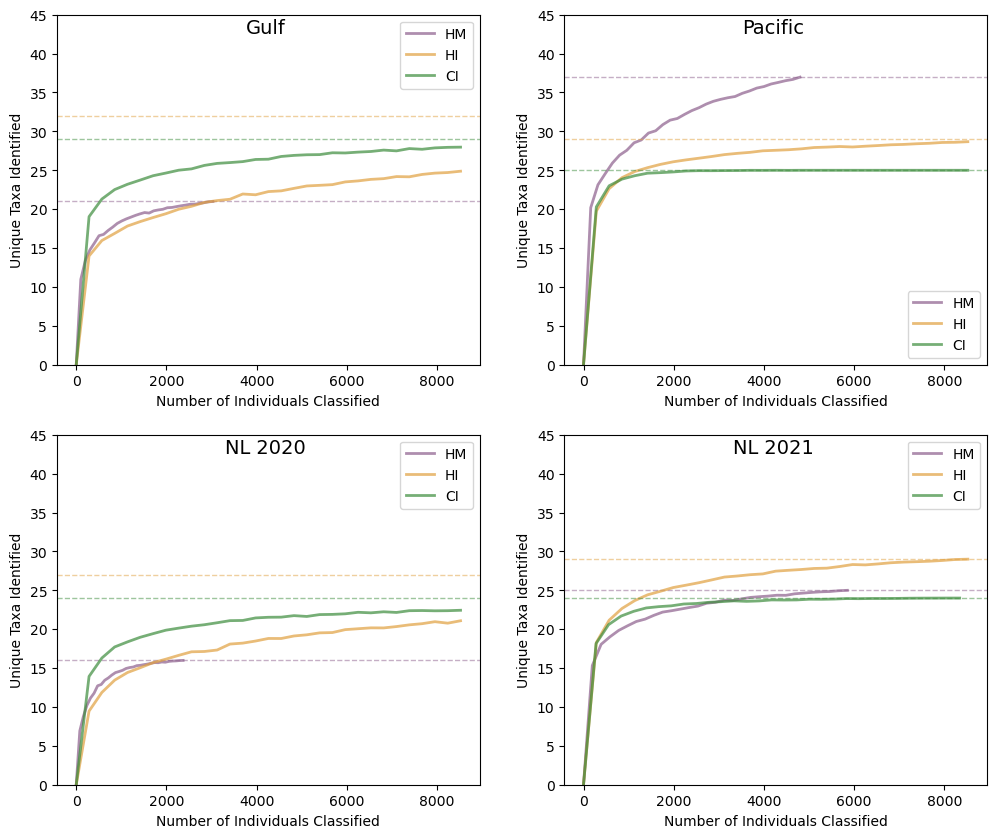

In [69]:
regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
colors = ['#75ba75', '#fec76f', '#be95be']
colors = ['#3c8c3c', '#e0a03f', '#8c5e8c']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for r, regionYear in enumerate(regionYears):
    row = r // 2  # Determine the row index
    col = r % 2   # Determine the column index
    ax = axes[row, col]  # Access the correct subplot
    richness = hm_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * hm_increments[regionYear], richness, alpha = .7, label='HM', linewidth=2, color=colors[2])
    ax.axhline(y=hm_total_species[regionYear], color=colors[2], linestyle='--', linewidth=1, alpha=0.5)
    richness = hi_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * hi_increments[regionYear], richness, alpha = .7, label='HI', linewidth=2, color=colors[1])
    ax.axhline(y=hi_total_species[regionYear], color=colors[1], linestyle='--', linewidth=1, alpha=0.5)
    richness = ci_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * ci_increments[regionYear], richness, alpha = .7, label='CI', linewidth=2, color=colors[0])
    ax.axhline(y=ci_total_species[regionYear], color=colors[0], linestyle='--', linewidth=1, alpha=0.5)
    ax.text(4200, 44.5, f'{regionYear}', ha='center', va='top', fontsize=14)
    ax.set_xlabel('Number of Individuals Classified')
    ax.set_ylabel('Unique Taxa Identified')
    ax.legend()
    # ax.set_xlim([0, 9000])
    ax.set_ylim([0, 45])
    # plt.xlim([0, 3000])
    # plt.grid(True)
plt.show()
plt.close()

In [104]:
# hiabund = datadf[datadf['type'] == 'FC'].copy()
# samples = hiabund['FlowCamID'].unique()
# countsdfs = []
# for sample in samples:
#     sampledf = hiabund[hiabund['FlowCamID'] == sample].copy()
#     sampledf['counts'] = sampledf['abund'] / np.min(sampledf['abund'])
#     countsdfs.append(sampledf)
#     counts = sampledf['counts'].to_numpy()
#     print(f'----------{sample}----------------------------------------------')
#     for i, row in sampledf.iterrows():
#         if row['counts'] % 1 < 0.0001 or count % 1 > .9999:
#             print(row['newName'], row['counts'])
#         else:
#             print(f"bad:...................... {row['newName']} {row['counts']}")
# countsdf = pd.concat(countsdfs).reset_index(drop=True)


In [21]:
datadf['newName'].unique()

array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Alciopidae sp.',
       'Amphipoda', 'Amphipoda- epibenthic', 'Anthoathecata (medusa)',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Calycophorae (nectophore)',
       'Centropages spp.', 'Chaetognatha', 'Chiridius spp.',
       'Cirripedia (larvae)', 'Cnidaria (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (juvenile/adult)', 'Ctenophora larvae',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Neoturris spp. (medusa)', 'Obeli

In [ ]:
cidf = datadf = pd.read_excel('strat4_5000.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})

regionYears = ci_rawcounts_df['regionYear'].unique()
print(regionYears)
ci_rawcounts_df['countSample'] = ci_rawcounts_df['countSample'].astype(int)
ci_region_richness = {}
ci_sum_counts = {}
ci_increments = {}
ci_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao2 = get_chao2(sample_counts)
    ci_region_richness[regionYear], ci_sum_counts[regionYear], ci_increments[regionYear], ci_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao2, max_sample = 10000)